In [1]:
from util import d, here, tic, toc
from NSynthDataSet_RawAudio import NSynthDataSet_RawAudio
from transformers import GTransformer

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import RandomSampler

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

from argparse import ArgumentParser

import random, sys, math, gzip, os
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
base_data_dir = '/home/purnima/appdir/Github/DATA/NSynth/'
train_data_dir = os.path.join(base_data_dir,'nsynth-train','audio')
test_data_dir = os.path.join(base_data_dir,'nsynth-test','audio')
validate_data_dir = os.path.join(base_data_dir,'nsynth-valid','audio')

labels_dir = '/home/purnima/appdir/Github/DATA/NSynth'
labels_file_name = 'examples.json'
# labels_file_name = 'examples-subset-full-acoustic-3000.json'

labels_train_dir = os.path.join(labels_dir,'nsynth-train', labels_file_name)
labels_test_dir = os.path.join(labels_dir,'nsynth-test', labels_file_name)
labels_validate_dir = os.path.join(labels_dir,'nsynth-valid', labels_file_name)

In [3]:
### Constants 

sample_rate = 16000

batch_size = 16
# lr = 0.0000005
lr = 0.0005
# lr_warmup = 5000
lr_warmup = 5000
epochs = 400

sample_length = 512 # For context
embedding_size = 128 
num_heads = 8 # Number of chunks for 'parallel/ensemble' computation
depth = 12 # Number of transformer layers
num_tokens = 256 #Size of the dictionary

# lower_pitch_limit = 60
# upper_pitch_limit = 74
lower_pitch_limit = 64
upper_pitch_limit = 76

### NSynth Dataset
Wav files for **guitar** instrument with pitch values from **40** to **88** are chosen. This selection leads to an initial dataset size of *15270* files. 

Each file can be sampled randomly 4 times between approximately 1 - 3 second timestamps to extract input and target of ***sample_length*** (currently 512) resulting in a total dataset size of ***15270 * 4 = 61080***

For each dataset.__getitem__ (one record of the dataset) if the input starts at 1 second time stamp (i.e. starting from 16000th sample) the target refers to samples starting from the 16001th sample. The samples are mu-law encoded and the results are shifted/adjusted to lie in between 0 to 255. 

Relevant constants:  
```
sample_rate = 16000  
batch_size = 16  
sample_length = 512 #(context)
```

In [9]:
train_ds = NSynthDataSet_RawAudio(meta_data_file=labels_train_dir, audio_dir=train_data_dir, sr=sample_rate, lower_pitch_limit=lower_pitch_limit, upper_pitch_limit=upper_pitch_limit, split='train')
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = NSynthDataSet_RawAudio(meta_data_file=labels_test_dir, audio_dir=test_data_dir, sr=sample_rate, lower_pitch_limit=lower_pitch_limit, upper_pitch_limit=upper_pitch_limit, split='test')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Validate dataset is not used at the moment.
# validate_ds = NSynthDataSet_RawAudio(meta_data_file=labels_validate_dir, audio_dir=validate_data_dir, sr=sample_rate)
# validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=batch_size, shuffle=False)


#2 instruments * 13 pitches * 10 amplitude scales * 79 start locs between 0.75 and 3.25 secs

(7800, 15)
Unique pitches =  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
(1500, 15)
Unique pitches =  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


In [10]:
def save_model(epoch, model, opt, loss, model_location):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'loss': loss,
        }, model_location) 
    print('Saved Model', flush=True)

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

### Define and Instantiate Transformer
  
Transformer architecture:  
1. 'Word' embedding layer is a `nn.Linear` layer (This replaces embedding layers in order to accomodate conditional params in future.)
2. 'Position' is a `nn.Linear` layer (to assign each sample a position - currently this is index of the sample in the array)
3. Sum of 'Word' and 'Position' embedding outputs
4. Sequential Transformer Blocks `depth` layers in number.
5. Single Linear layer
6. Log softmax (We are using Negative Log Likelihood loss function which needs log probabilities)

Relevant constants (defined previously):   
```
sample_length = 512 #For context
num_heads = 8 
depth = 12 #Number of transformer blocks in Sequential
num_tokens = 255 #Dictionary size. In our case levels from our companding. 
```

Our sequence is of length 512 samples. Output shapes from each layer --  
  
* Input to the model = `batch_size X sample_length X 1` i.e. 16 X 512 X 1  
* Output from 'Word' embedding linear layer = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128   
* Output from 'Position' embedding = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128  
* Output from 'Word' + 'Position' embedding = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128 (sum and not concat)
* Attention Layers:
    * Keys/queries/values shape = `batch_size X seq_length X num_heads X embedding_size//num_heads` i.e. 16 X 512 X 8 X 16
    * Dot product of query and key: \\(softmax(\frac{Q \cdot K}{\sqrt{seq\_length}}) \cdot V \\) shape = `batch_size X seq_length X embedding_size`. Actual impl slightly different => [\\( softmax(\frac{Q}{seq\_length^{\frac{1}{4}}} \cdot \frac{K}{seq\_length^{\frac{1}{4}}}) \cdot V\\)]
    * Output after unifying heads = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128
    * Output after feedforward and Norm blocks = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128

* Output from Transformer Sequential Blocks = `batch_size X seq_length X embedding_size` i.e. 16 X 512 X 128  
* Output from Linear Layer (in preparation of the softmax layer) = `batch_size X seq_length X num_tokens` (or dictionary size) i.e. 16 X 512 X 256  
* Output from Log softmax = `batch_size X seq_length X num_tokens` i.e. 16 X 512 X 256  

In [11]:
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model = model.cuda()

opt = torch.optim.Adam(lr=lr, params=model.parameters())#, weight_decay=0.01)
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0), verbose=False)
loss = torch.nn.NLLLoss(reduction='mean')

In [12]:
print(model)

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=128, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=512, out_features=128, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Se

## Training Loss Function

The NLL loss or Negative log likelihood accepts an input of log-probabilities of each 'class' (typically outputs from a log softmax function) of shape `batch_size X num_classes` or in our case `batch_size X num_tokens`   

See: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

In [13]:
def train():
    training_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch:{epoch}')):
        opt.zero_grad()
        
        b, cols, seq_len = data.shape
        reshaped_data = data.view(b, seq_len, cols)
        reshaped_data = reshaped_data.cuda().float()
#         conditioning = conditioning.view(b, seq_len, 1)
#         conditioning = conditioning.cuda().float()
        target = target.cuda()
        
        output = model(reshaped_data)
        running_loss = loss(output.transpose(2, 1), target)
        training_loss += running_loss.item()

        running_loss.backward() # backward pass
        
        gradient_clipping = 1.0
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

        opt.step() # stochastic gradient descent step
        sch.step()
    
#     sch.step()
    training_loss /= len(train_loader)
    print('Epoch last LR = ', sch.get_last_lr(), flush=True)
    return training_loss

def test():
    model.eval()
    testing_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc='Testing')):

            b, cols, seq_len = data.shape
            reshaped_data = data.view(b, seq_len, cols)
            reshaped_data = reshaped_data.cuda().float()
#             conditioning = conditioning.view(b, seq_len, 1)
#             conditioning = conditioning.cuda().float()
            target = target.cuda()
            
            output = model(reshaped_data)

            running_loss = loss(output.transpose(2, 1), target)
            testing_loss += running_loss.item()

    # # To improve legibility only one loss norm is plotted for an epoch (Goodfellow - pg 276 diag 8.1)
    testing_loss /= len(test_loader)
    return testing_loss


Epoch:0: 100%|██████████| 488/488 [01:04<00:00,  7.59it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.41it/s]


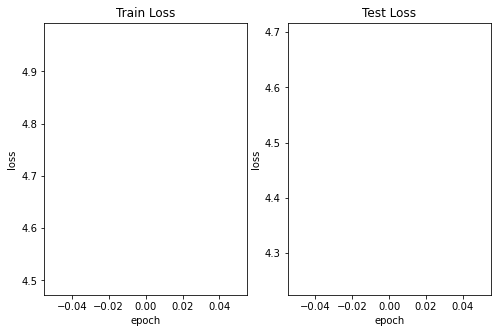

Saved Model


Epoch:1: 100%|██████████| 488/488 [01:04<00:00,  7.62it/s]

Epoch last LR =  [0.0005]



Epoch:2: 100%|██████████| 488/488 [01:04<00:00,  7.56it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.01it/s]


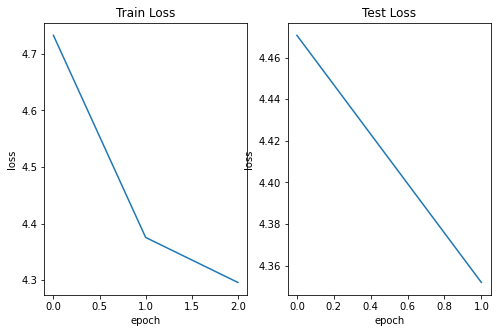

Saved Model


Epoch:3: 100%|██████████| 488/488 [01:04<00:00,  7.57it/s]

Epoch last LR =  [0.0005]



Epoch:4: 100%|██████████| 488/488 [01:04<00:00,  7.56it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.05it/s]


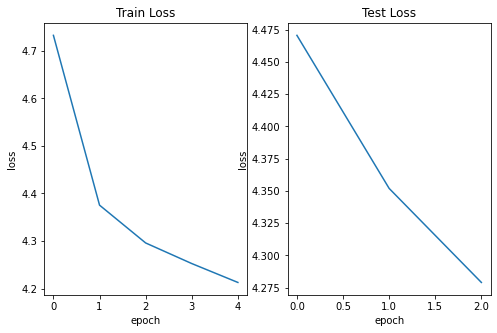

Saved Model


Epoch:5: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:6: 100%|██████████| 488/488 [01:04<00:00,  7.54it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.20it/s]


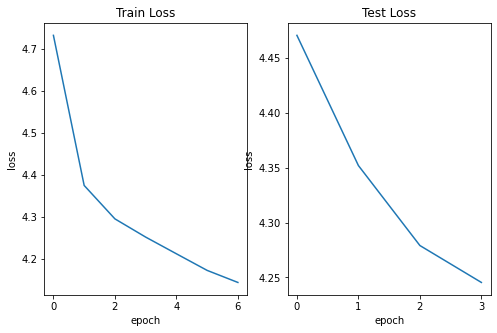

Saved Model


Epoch:7: 100%|██████████| 488/488 [01:04<00:00,  7.52it/s]

Epoch last LR =  [0.0005]



Epoch:8: 100%|██████████| 488/488 [01:04<00:00,  7.57it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


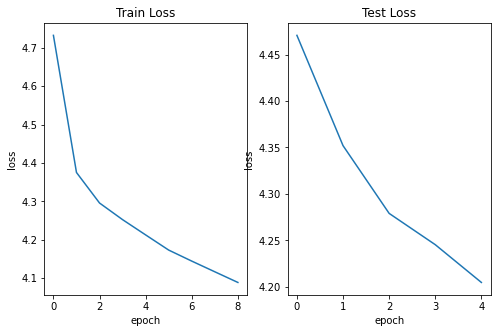

Saved Model


Epoch:9: 100%|██████████| 488/488 [01:04<00:00,  7.54it/s]

Epoch last LR =  [0.0005]



Epoch:10: 100%|██████████| 488/488 [01:04<00:00,  7.54it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.21it/s]


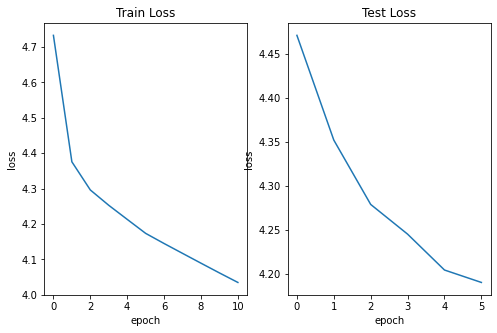

Saved Model


Epoch:11: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:12: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.79it/s]


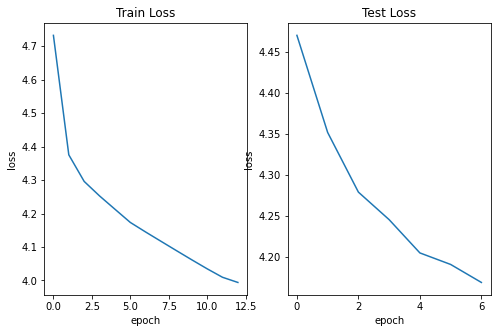

Saved Model


Epoch:13: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Epoch:14: 100%|██████████| 488/488 [01:05<00:00,  7.49it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.32it/s]


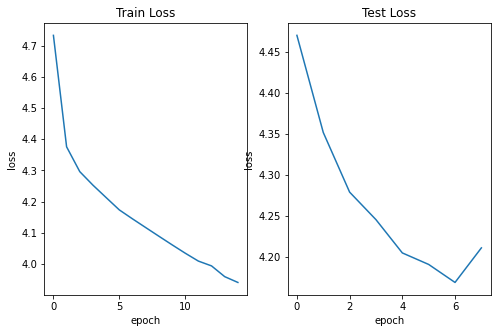

Saved Model


Epoch:15: 100%|██████████| 488/488 [01:05<00:00,  7.43it/s]

Epoch last LR =  [0.0005]



Epoch:16: 100%|██████████| 488/488 [01:06<00:00,  7.39it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.91it/s]


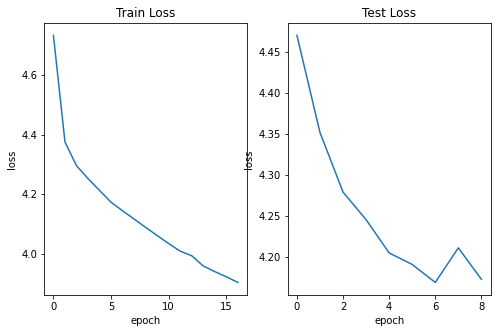

Saved Model


Epoch:17: 100%|██████████| 488/488 [01:06<00:00,  7.38it/s]

Epoch last LR =  [0.0005]



Epoch:18: 100%|██████████| 488/488 [01:04<00:00,  7.55it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.48it/s]


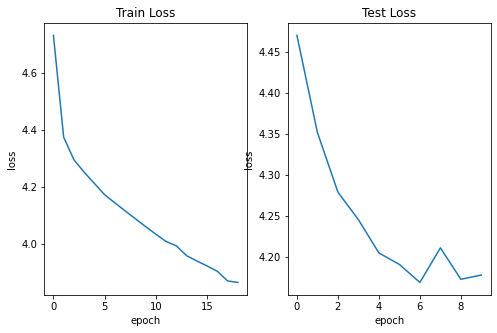

Saved Model


Epoch:19: 100%|██████████| 488/488 [01:04<00:00,  7.52it/s]

Epoch last LR =  [0.0005]



Epoch:20: 100%|██████████| 488/488 [01:05<00:00,  7.49it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s]


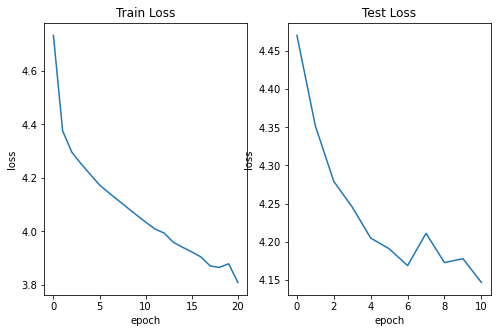

Saved Model


Epoch:21: 100%|██████████| 488/488 [01:06<00:00,  7.35it/s]

Epoch last LR =  [0.0005]



Epoch:22: 100%|██████████| 488/488 [01:05<00:00,  7.40it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.12it/s]


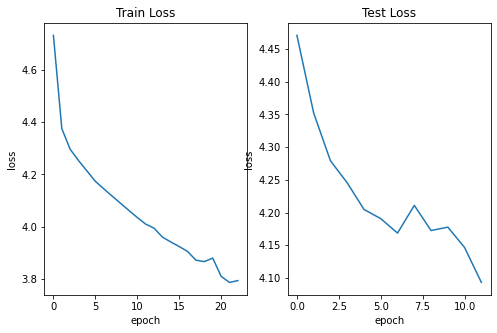

Saved Model


Epoch:23: 100%|██████████| 488/488 [01:06<00:00,  7.36it/s]

Epoch last LR =  [0.0005]



Epoch:24: 100%|██████████| 488/488 [01:06<00:00,  7.32it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.33it/s]


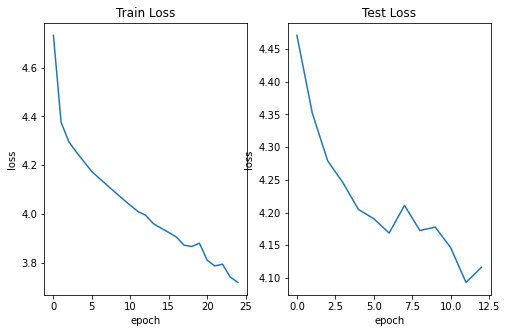

Saved Model


Epoch:25: 100%|██████████| 488/488 [01:06<00:00,  7.37it/s]

Epoch last LR =  [0.0005]



Epoch:26: 100%|██████████| 488/488 [01:05<00:00,  7.45it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.40it/s]


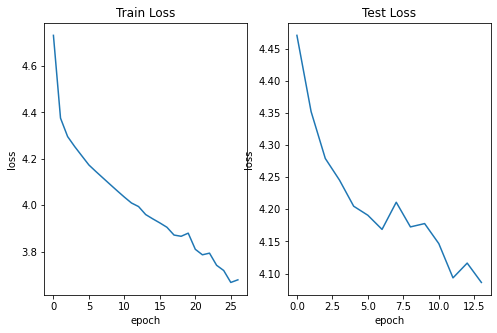

Saved Model


Epoch:27: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Epoch:28: 100%|██████████| 488/488 [01:04<00:00,  7.55it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s]


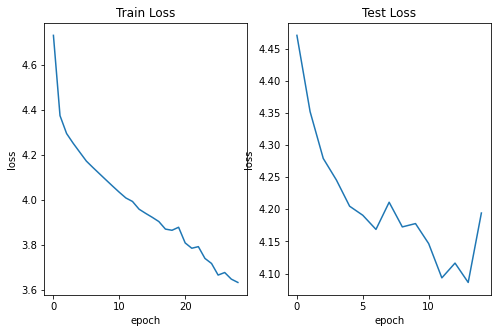

Saved Model


Epoch:29: 100%|██████████| 488/488 [01:04<00:00,  7.55it/s]

Epoch last LR =  [0.0005]



Epoch:30: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


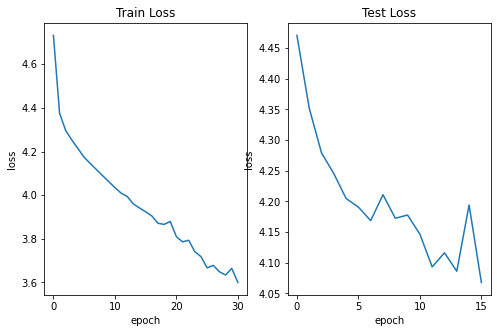

Saved Model


Epoch:31: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:32: 100%|██████████| 488/488 [01:05<00:00,  7.47it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.89it/s]


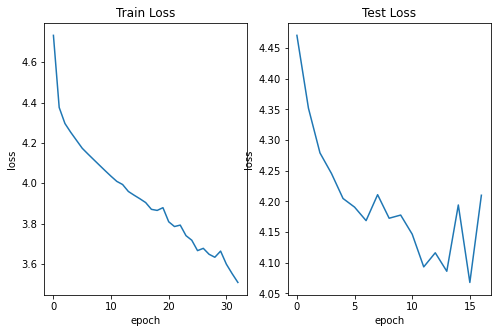

Saved Model


Epoch:33: 100%|██████████| 488/488 [01:06<00:00,  7.35it/s]

Epoch last LR =  [0.0005]



Epoch:34: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.91it/s]


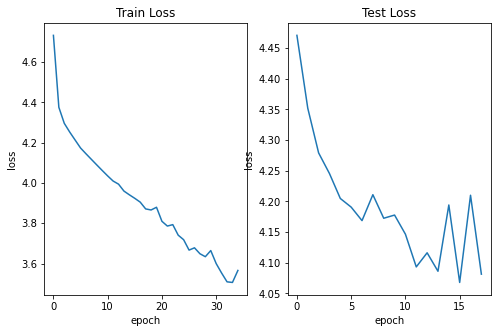

Saved Model


Epoch:35: 100%|██████████| 488/488 [01:05<00:00,  7.45it/s]

Epoch last LR =  [0.0005]



Epoch:36: 100%|██████████| 488/488 [01:05<00:00,  7.49it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.92it/s]


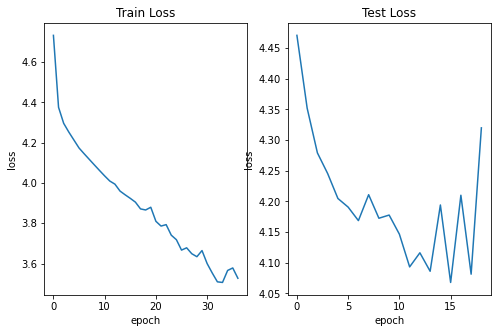

Saved Model


Epoch:37: 100%|██████████| 488/488 [01:05<00:00,  7.45it/s]

Epoch last LR =  [0.0005]



Epoch:38: 100%|██████████| 488/488 [01:06<00:00,  7.36it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s]


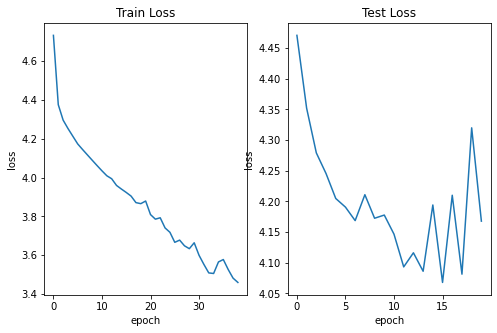

Saved Model


Epoch:39: 100%|██████████| 488/488 [01:07<00:00,  7.22it/s]

Epoch last LR =  [0.0005]



Epoch:40: 100%|██████████| 488/488 [01:05<00:00,  7.42it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.30it/s]


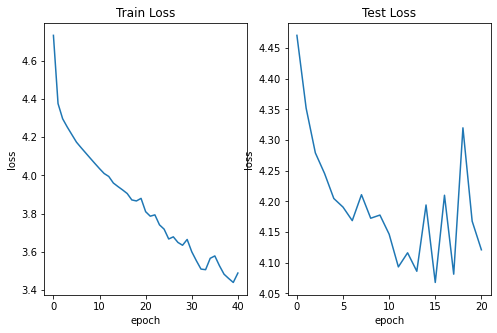

Saved Model


Epoch:41: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:42: 100%|██████████| 488/488 [01:04<00:00,  7.54it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.30it/s]


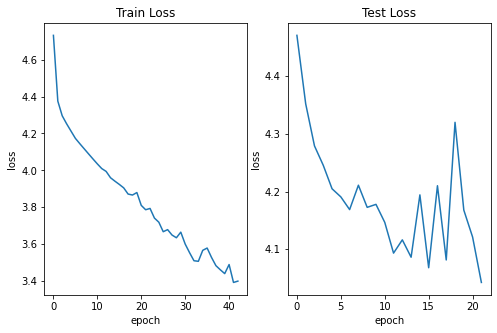

Saved Model


Epoch:43: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:44: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.29it/s]


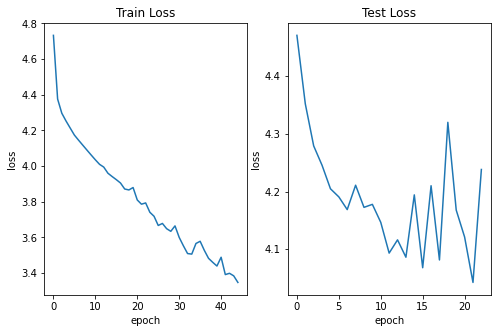

Saved Model


Epoch:45: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Epoch:46: 100%|██████████| 488/488 [01:05<00:00,  7.47it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s]


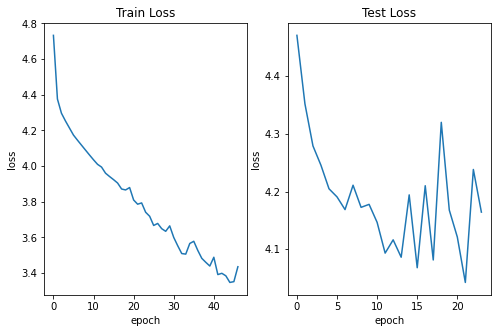

Saved Model


Epoch:47: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:48: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.32it/s]


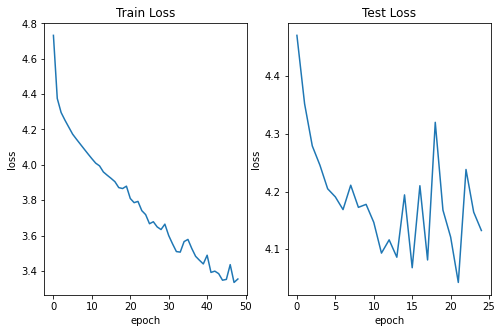

Saved Model


Epoch:49: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:50: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.45it/s]


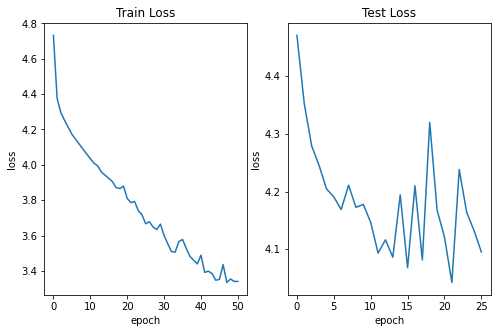

Saved Model


Epoch:51: 100%|██████████| 488/488 [01:05<00:00,  7.48it/s]

Epoch last LR =  [0.0005]



Epoch:52: 100%|██████████| 488/488 [01:05<00:00,  7.47it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.30it/s]


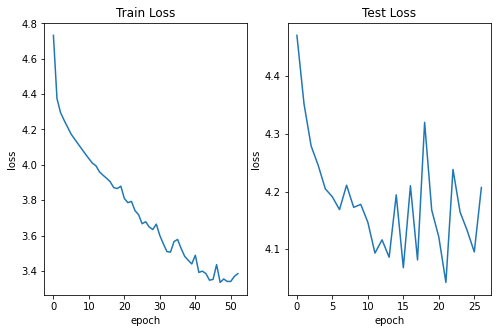

Saved Model


Epoch:53: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Epoch:54: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.28it/s]


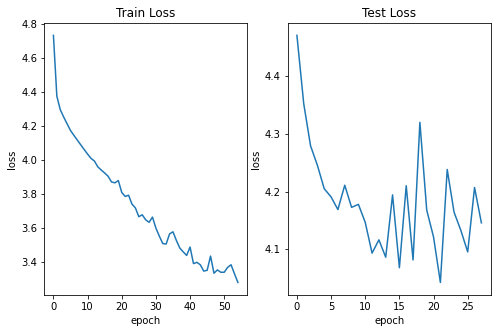

Saved Model


Epoch:55: 100%|██████████| 488/488 [01:04<00:00,  7.52it/s]

Epoch last LR =  [0.0005]



Epoch:56: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.27it/s]


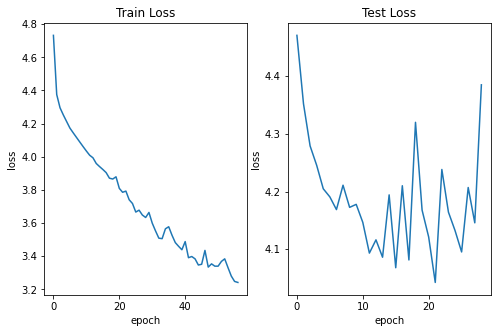

Saved Model


Epoch:57: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Epoch:58: 100%|██████████| 488/488 [01:04<00:00,  7.52it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.26it/s]


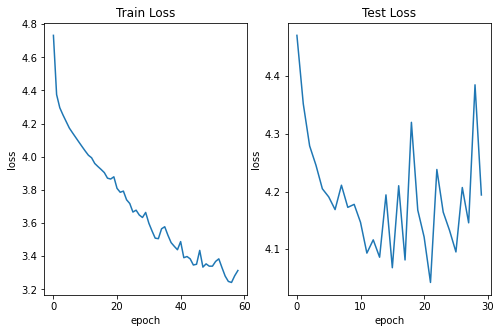

Saved Model


Epoch:59: 100%|██████████| 488/488 [01:08<00:00,  7.15it/s]

Epoch last LR =  [0.0005]



Epoch:60: 100%|██████████| 488/488 [01:06<00:00,  7.33it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.25it/s]


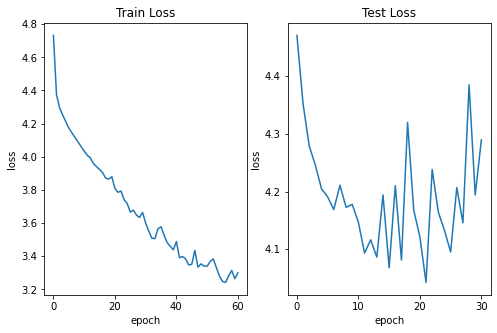

Saved Model


Epoch:61: 100%|██████████| 488/488 [01:05<00:00,  7.48it/s]

Epoch last LR =  [0.0005]



Epoch:62: 100%|██████████| 488/488 [01:05<00:00,  7.43it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.81it/s]


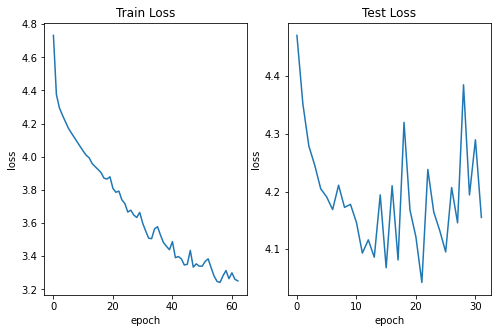

Saved Model


Epoch:63: 100%|██████████| 488/488 [01:05<00:00,  7.41it/s]

Epoch last LR =  [0.0005]



Epoch:64: 100%|██████████| 488/488 [01:06<00:00,  7.38it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.84it/s]


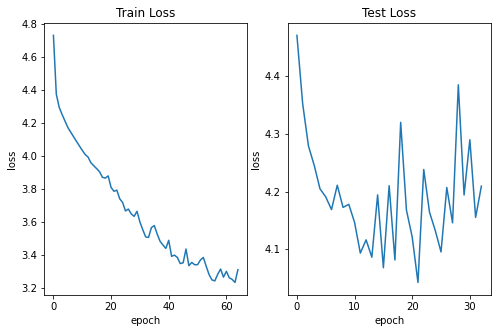

Saved Model


Epoch:65: 100%|██████████| 488/488 [01:05<00:00,  7.44it/s]

Epoch last LR =  [0.0005]



Epoch:66: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s]


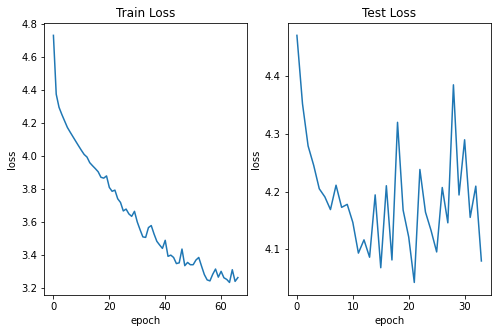

Saved Model


Epoch:67: 100%|██████████| 488/488 [01:05<00:00,  7.42it/s]

Epoch last LR =  [0.0005]



Epoch:68: 100%|██████████| 488/488 [01:04<00:00,  7.54it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


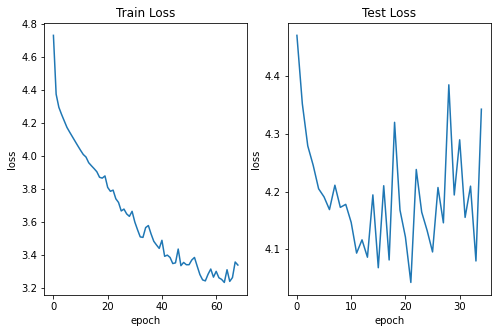

Saved Model


Epoch:69: 100%|██████████| 488/488 [01:04<00:00,  7.55it/s]

Epoch last LR =  [0.0005]



Epoch:70: 100%|██████████| 488/488 [01:04<00:00,  7.56it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.43it/s]


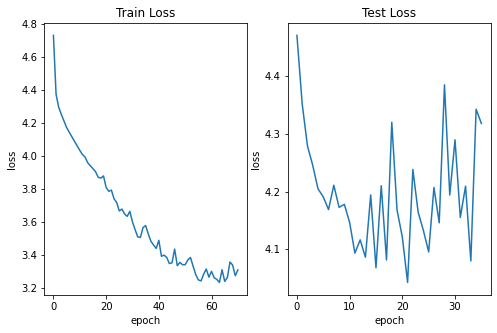

Saved Model


Epoch:71: 100%|██████████| 488/488 [01:04<00:00,  7.53it/s]

Epoch last LR =  [0.0005]



Epoch:72: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


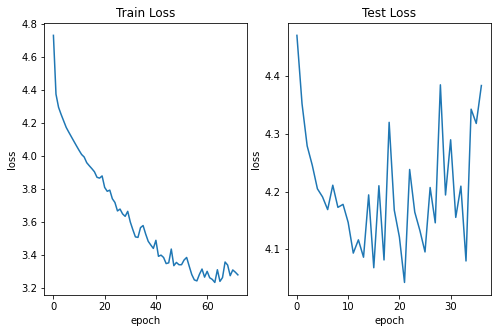

Saved Model


Epoch:73: 100%|██████████| 488/488 [01:05<00:00,  7.44it/s]

Epoch last LR =  [0.0005]



Epoch:74: 100%|██████████| 488/488 [01:05<00:00,  7.43it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


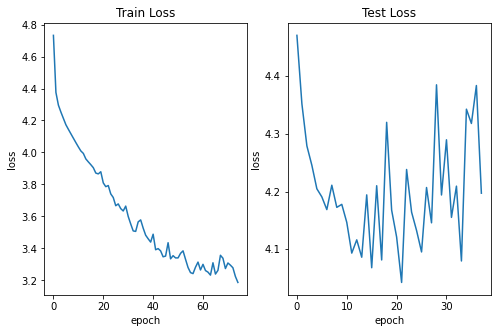

Saved Model


Epoch:75: 100%|██████████| 488/488 [01:05<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Epoch:76: 100%|██████████| 488/488 [01:05<00:00,  7.50it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.24it/s]


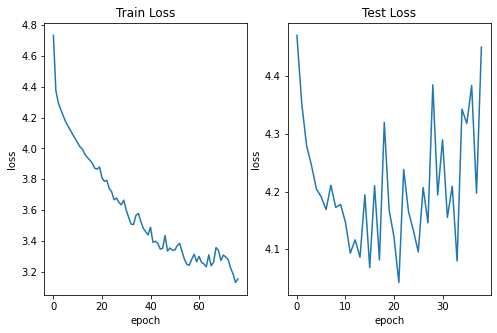

Saved Model


Epoch:77: 100%|██████████| 488/488 [01:05<00:00,  7.47it/s]

Epoch last LR =  [0.0005]



Epoch:78: 100%|██████████| 488/488 [01:05<00:00,  7.48it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.98it/s]


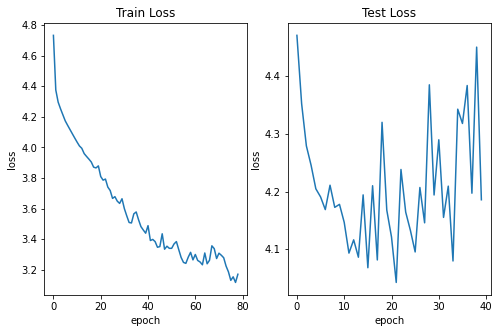

Saved Model


Epoch:79: 100%|██████████| 488/488 [01:06<00:00,  7.39it/s]

Epoch last LR =  [0.0005]



Epoch:80: 100%|██████████| 488/488 [01:06<00:00,  7.35it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 20.86it/s]


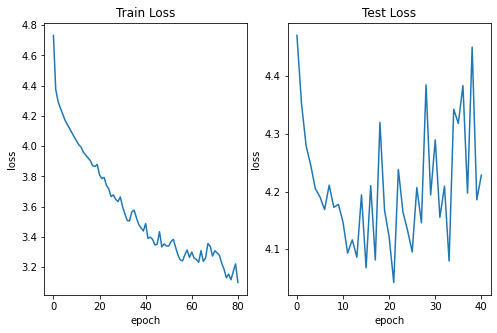

Saved Model


Epoch:81: 100%|██████████| 488/488 [01:05<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Epoch:82: 100%|██████████| 488/488 [01:04<00:00,  7.52it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.37it/s]


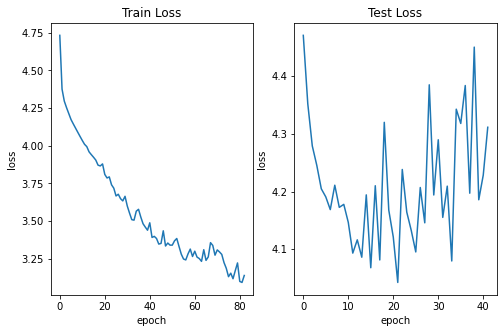

Saved Model


Epoch:83: 100%|██████████| 488/488 [01:05<00:00,  7.46it/s]

Epoch last LR =  [0.0005]



Epoch:84: 100%|██████████| 488/488 [01:04<00:00,  7.51it/s]

Epoch last LR =  [0.0005]



Testing: 100%|██████████| 94/94 [00:04<00:00, 21.38it/s]


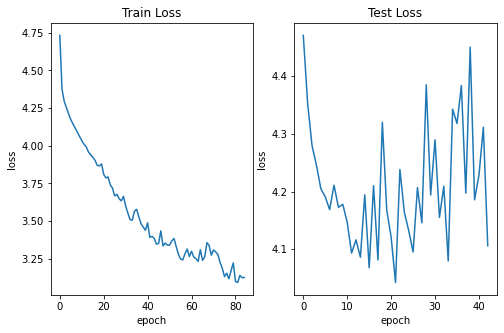

Saved Model


Epoch:85:  69%|██████▉   | 338/488 [00:45<00:20,  7.50it/s]

In [ ]:
history_train = {'loss': []}
history_test = {'loss': []}

for epoch in range(0, epochs, 1):
    train_loss = train()
    history_train['loss'].append(train_loss)
    
    if epoch%2 == 0 or epoch == epochs-1:
        test_loss = test()
        history_test['loss'].append(test_loss)
        
        fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
        axes[0].plot(history_train['loss'])
        axes[0].set_title('Train Loss')
        axes[0].set_xlabel('epoch')
        axes[0].set_ylabel('loss')
        
        axes[1].plot(history_test['loss'])
        axes[1].set_title('Test Loss')
        axes[1].set_xlabel('epoch')
        axes[1].set_ylabel('loss')
        plt.show()

        save_model(epoch, model, opt, loss, f'checkpoint/attention-{epoch}.pt')